## Image Transformations
****

As you mentioned in Module 1, you can think of a (grayscale) image as a function:
$$ f: \mathbb{R}^2 \rightarrow \mathbb{R} $$
where 
$$ f(x,y) $$
gives the intensity at position 
$$ (x,y) $$

So you can transform the image by adjusted the function $f(x,y)$

A common approach is to adjust the intensity levels of the image using a linear scaling function:

$$
\text{output} = \alpha \times \text{input} + \beta
$$

Where:
- $ \alpha $ is the gain or contrast control. Values $ > 1 $ increase contrast, and values between 0 and 1 decrease contrast.
- $ \beta $ is the bias or brightness control.



<b>Brightness</b>: This is the adjustment of the lightness or darkness of an image. An image's brightness can be increased by adding a constant to every pixel value of the image.

<b>Contrast:</b> This represents the difference between the darkest and lightest regions of an image. The contrast can be increased by multiplying every pixel value of the image by a constant.

<img src="Graphics/brightness.png">


93


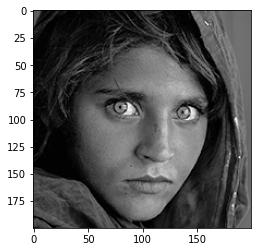

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_brightness_contrast(image_array, alpha, beta):
    # Adjust contrast and brightness of the image array. Converting to floating point to
    # avoid overflow and underflow losses.
    temp = image_array.astype('float32')
    
    # Adjust contrast by multiplying each pixel value
    temp *= alpha
    
    # Adjust brightness by adding to every value.
    temp += beta

    # Clip values to be in the range [0, 255]
    temp = np.clip(temp, 0, 255)
    
    return temp.astype('uint8')

# Load Image
image = cv2.imread("Graphics/face.png")
# Convert image_data to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


adjusted_image_data = adjust_brightness_contrast(image, 1, 0)  # 1.5 is alpha (contrast), 50 is beta (brightness)

plt.imshow(adjusted_image_data, cmap="gray")
print(image[0,0])